In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [117]:
circuit_name = "Canada"
lap_data = pd.read_csv("./datasets/lapdata/Miami_Grand_Prix.csv")
telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

In [3]:
driver_id = "VER"

### Lap data analysis

In [4]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
print(driver_race_time)
print(driver_laps.head())

01:28:22.455000
    DriverNumber Driver  LapNumber Compound  TyreLife  Sector1Time  \
57             1    VER        1.0   MEDIUM       1.0          NaN   
58             1    VER        2.0   MEDIUM       2.0       31.455   
59             1    VER        3.0   MEDIUM       3.0       31.551   
60             1    VER        4.0   MEDIUM       4.0       31.508   
61             1    VER        5.0   MEDIUM       5.0       31.318   

    Sector2Time  Sector3Time  LapTime  
57       34.990       26.211   94.338  
58       35.489       26.149   93.093  
59       35.472       26.114   93.137  
60       35.686       26.310   93.504  
61       35.410       26.106   92.834  


Text(0.5, 1.0, 'Driver lap times')

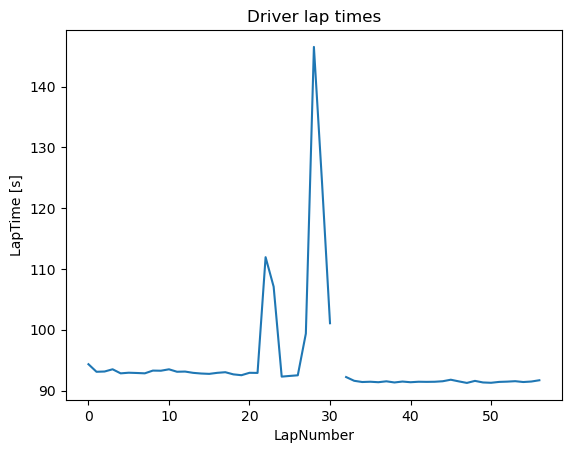

In [5]:
plt.figure()
plt.plot(np.arange(len(driver_laps)), driver_laps["LapTime"])
plt.xlabel("LapNumber")
plt.ylabel("LapTime [s]")
plt.title("Driver lap times")

### Track analysis

         lon        lat           x          y
0 -80.236636  25.955895    0.000000   0.000000
1 -80.236928  25.955822  -32.505291  -9.037969
2 -80.237221  25.955763  -65.121902 -16.342625
3 -80.237653  25.955754 -113.211922 -17.456894
4 -80.237992  25.955809 -150.949230 -10.647470


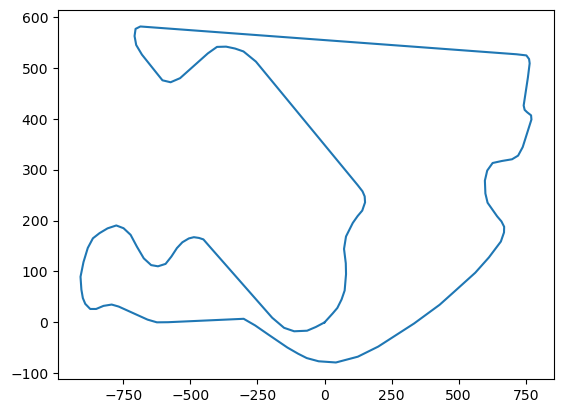

In [84]:
import json

track_name = "Miami"

# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

# Select track coordinates
select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])


def latlon_to_xy(lat, lon, origin_lat=track_data["lat"][0], origin_lon=track_data["lon"][0]):

    # WGS84 ellipsoid constants
    EARTH_RADIUS = 6378137.0  # Earth's radius in meters
    
    def deg_to_rad(degrees):
        return degrees * (np.pi / 180.0)
    
    # Convert to radians
    lat_rad = deg_to_rad(lat)
    lon_rad = deg_to_rad(lon)
    origin_lat_rad = deg_to_rad(origin_lat)
    origin_lon_rad = deg_to_rad(origin_lon)
    
    # Mercator projection
    x = EARTH_RADIUS * (lon_rad - origin_lon_rad)
    y = EARTH_RADIUS * np.log(
        np.tan(np.pi/4 + lat_rad/2) / 
        np.tan(np.pi/4 + origin_lat_rad/2)
    )
    
    return pd.Series([x, y])

# Convert latlon track coordinates to xy coordinates
track_data[["x", "y"]] = track_data.apply(lambda row: latlon_to_xy(row["lat"], row["lon"]), axis=1)

print(track_data.head())
plt.plot(track_data["x"], track_data["y"])


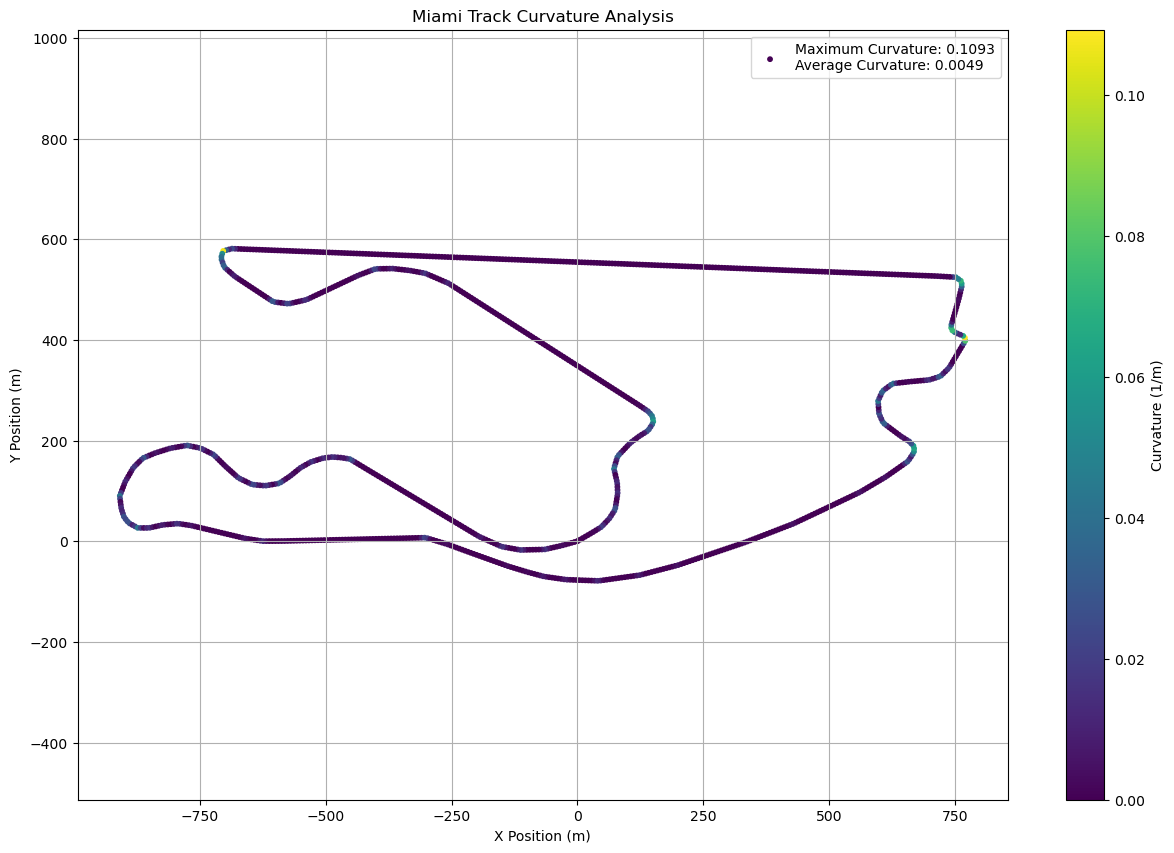

Maximum curvature: 0.1093 m^-1
Average curvature: 0.0049 m^-1
Minimum curvature: 0.0000 m^-1


In [81]:
from scipy.interpolate import splprep, splev

def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using the formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

def plot_track_curvature(x, y, curvature):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='viridis', 
                        s=10, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


x_smooth, y_smooth = smooth_track_data(track_data["x"].values, track_data["y"].values)

curvature = calculate_curvature(x_smooth, y_smooth)

plot_track_curvature(x_smooth, y_smooth, curvature)

print(f"Maximum curvature: {np.max(curvature):.4f} m^-1")
print(f"Average curvature: {np.mean(curvature):.4f} m^-1")
print(f"Minimum curvature: {np.min(curvature):.4f} m^-1")


### Telemetry data analysis

In [118]:
print(telem_data.head())
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "Brake", "DRS", "LapNumber"]]

driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)

driver_telemetry.head(n=10)

                      Date    RPM  Speed  nGear  Throttle  Brake  DRS  \
0  2024-06-09 18:03:11.605  10035      0      2        17   True    1   
1  2024-06-09 18:03:11.652  10015      0      2        17   True    1   
2  2024-06-09 18:03:11.853  10059      0      2        17   True    1   
3  2024-06-09 18:03:11.897   9723      0      2        17   True    1   
4  2024-06-09 18:03:12.173   9387      0      2        17  False    1   

                     Time             SessionTime  DriverAhead  \
0         0 days 00:00:00  0 days 00:04:05.608000          NaN   
1  0 days 00:00:00.047000  0 days 00:04:05.655000          NaN   
2  0 days 00:00:00.248000  0 days 00:04:05.856000          NaN   
3  0 days 00:00:00.292000  0 days 00:04:05.900000          NaN   
4  0 days 00:00:00.568000  0 days 00:04:06.176000         81.0   

   DistanceToDriverAhead            X            Y  LapNumber  TrackStatus  \
0               0.088889  3282.913546  1287.170401        1.0           12   
1       

,RPM,Speed,nGear,Throttle,Brake,DRS,LapNumber
Date,,,,,,,
2024-06-09 18:03:11.605,10035,0,2,17,True,1,1.0
2024-06-09 18:03:11.652,10015,0,2,17,True,1,1.0
2024-06-09 18:03:11.853,10059,0,2,17,True,1,1.0
2024-06-09 18:03:11.897,9723,0,2,17,True,1,1.0
2024-06-09 18:03:12.173,9387,0,2,17,False,1,1.0
2024-06-09 18:03:12.317,8407,5,2,17,False,1,1.0
2024-06-09 18:03:12.453,7427,10,2,17,False,1,1.0
2024-06-09 18:03:12.557,6447,12,2,17,False,1,1.0
2024-06-09 18:03:12.733,5467,15,2,17,False,1,1.0


Text(0.5, 1.0, 'Timeseries data sampling step')

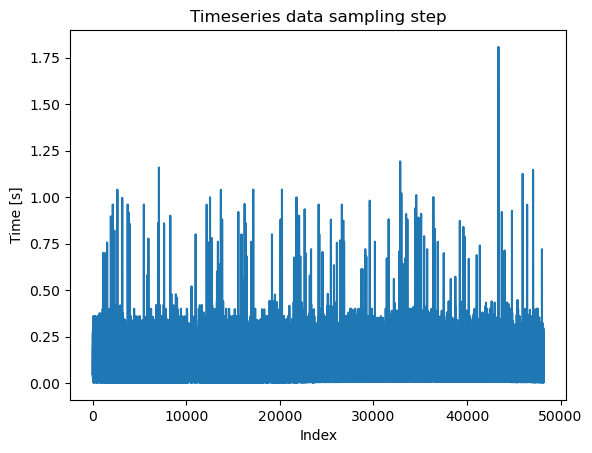

In [119]:
########### Check data sampling step ###########
DT = (driver_telemetry.index[1:] - driver_telemetry.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_telemetry.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

               Speed  Acceleration
LapNumber                         
1.0        41.210647      5.353080
2.0        44.524236      5.653125
3.0        45.100993      5.791116
4.0        45.719054      5.964104
5.0        46.143493      6.054909


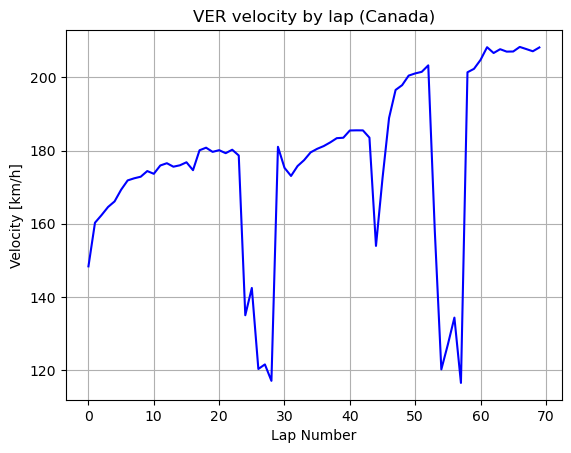

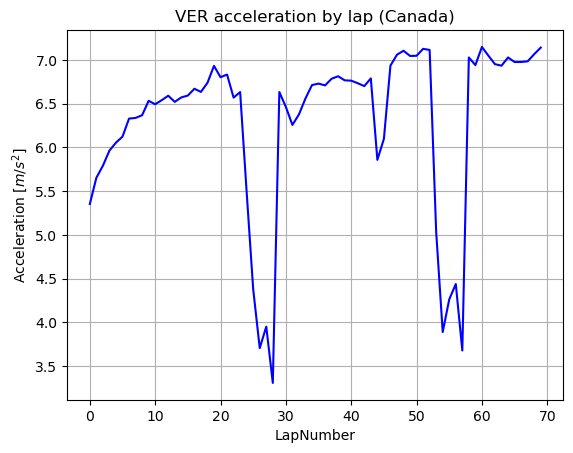

In [120]:
car_data = pd.DataFrame(
    {
        "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
        "LapNumber": driver_telemetry["LapNumber"].values
    },
    index = driver_telemetry.index
)

########### Resample and aggregate selected data ###########

downsampled_groups = []
for lap, lap_data in car_data.groupby('LapNumber'):
    lap_downsampled = lap_data.resample('1S').agg({
        'Speed': 'mean',
        'LapNumber': 'first'
    })
    
    downsampled_groups.append(lap_downsampled)

resampled_car_data = pd.concat(downsampled_groups).sort_index()

########### Calculate car acceleration ###########

dt = 1.0
#acceleration = abs(resampled_car_data["Speed"].values[1:] - resampled_car_data["Speed"].values[:-1]) / dt
#acceleration = np.insert(acceleration, 0, 0.0)
acceleration = np.abs(np.gradient(resampled_car_data["Speed"].values))

resampled_car_data["Acceleration"] = acceleration


########### Calculate and display car mean velocity and acceleration by lap ###########

car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()
print(car_data_by_lap.head())

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["Speed"])), car_data_by_lap["Speed"].values * 3.6, c='blue')
plt.xlabel("Lap Number")
plt.ylabel("Velocity [km/h]")
plt.title(f"{driver_id} velocity by lap ({circuit_name})")
plt.grid()
plt.figure()
plt.plot(np.arange(len(car_data_by_lap["Acceleration"])), car_data_by_lap["Acceleration"].values, c='blue')
plt.xlabel("LapNumber")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.title(f"{driver_id} acceleration by lap ({circuit_name})")
plt.grid()

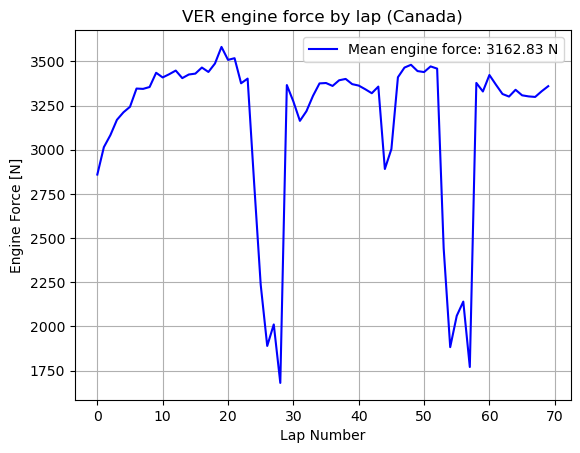

In [121]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7

n_laps = len(car_data_by_lap)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

engine_force_data = []
for accel in car_data_by_lap["Acceleration"].values:
    engine_force_data.append((m_total * accel) / mu)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["EngineForce"] = engine_force_data

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["EngineForce"])), car_data_by_lap["EngineForce"].values, label=f"Mean engine force: {np.mean(engine_force_data):.2f} N", c='blue')
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title(f"{driver_id} engine force by lap ({circuit_name})")
plt.legend()
plt.grid()


### Testing section

Text(0.5, 1.0, 'Friction by lap')

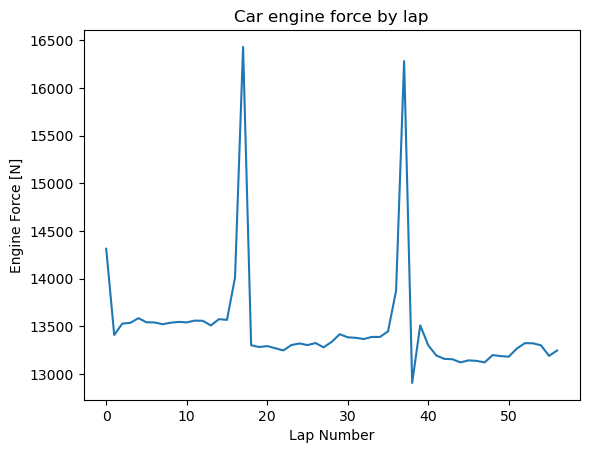

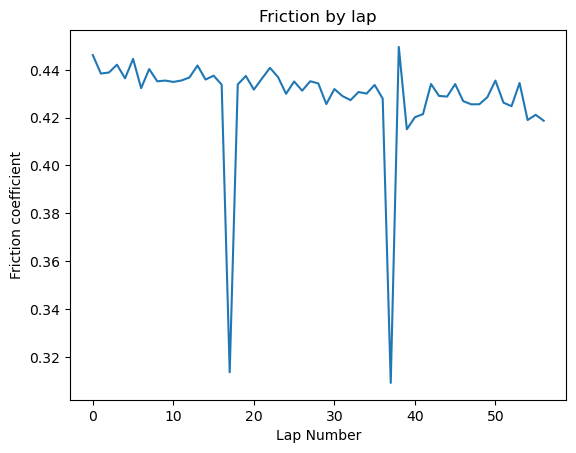

In [10]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7
red_bull_car_power = 750000 # In Watts

car_data_by_lap["EngineForce"] = red_bull_car_power / car_data_by_lap["Speed"]

m_total = m_car + m_fuel
fuel_consumption = m_fuel / len(car_data_by_lap) # Linear fuel consuption by each lap

car_friction_data = []
for accel, engine_force in zip(car_data_by_lap["Acceleration"].values, car_data_by_lap["EngineForce"].values):
    car_friction_data.append((m_total * accel) / engine_force)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["FrictionCoeff"] = car_friction_data

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["EngineForce"])), car_data_by_lap["EngineForce"].values)
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title("Car engine force by lap")
plt.figure()
plt.plot(np.arange(len(car_data_by_lap["FrictionCoeff"])), car_data_by_lap["FrictionCoeff"].values)
plt.xlabel("Lap Number")
plt.ylabel("Friction coefficient")
plt.title("Friction by lap")
